<a href="https://colab.research.google.com/github/Xenonimous/Garbage/blob/master/TestModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Checking Tensorflow version (Optional)


Before running the shell please make sure that you have changed Runtime 
Type into GPU



In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Importing Libraries

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
import random

from google.colab import files

print("\u2022 Using TensorFlow Version:", tf.__version__)

• Using TensorFlow Version: 2.5.0


Installing kaggle to colab

In [3]:
! pip install -q kaggle

Importing Files to colab with kaggle.json

In [4]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rianm2482358","key":"f247ba600cae259f51821a4c1e959d9e"}'}

Making kaggle directory

In [5]:
 ! mkdir ~/.kaggle
 ! cp kaggle.json ~/.kaggle/
 ! chmod 600 ~/.kaggle/kaggle.json

Downloading Garbage Classification dataset from Kaggle

In [6]:
! kaggle datasets download -d asdasdasasdas/garbage-classification

 93% 76.0M/82.0M [00:00<00:00, 56.5MB/s]
100% 82.0M/82.0M [00:00<00:00, 99.2MB/s]


Unzipping the dataset

In [7]:
! unzip garbage-classification.zip -d temp
! mv temp/Garbage\ classification/Garbage\ classification .
! rm -r temp
! mv Garbage\ classification datasets



Streaming output truncated to the last 5000 lines.
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard152.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard153.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard154.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard155.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard156.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard157.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard158.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard159.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard16.jpg  
  inflating: temp/Garbage classification/Garbage classification/cardboard/cardboard160.jpg  
  inflating: temp/Ga

Splitting Training, Testing, and Validation dataset

In [8]:
#Download and Install split_folders package
! pip install split-folders

In [9]:
#Split datasets into new folder
import splitfolders
splitfolders.ratio('/content/datasets/', output="datasplit", seed=1337, ratio=(.7, 0.15,0.15))

Copying files: 2527 files [00:00, 8546.43 files/s]


Generating data for training, testing, and validating

In [10]:
train_dir = '../content/datasplit/train/'
test_dir = '../content/datasplit/test/'
val_dir = '../content/datasplit/val/'

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
    )

datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (192, 192)
    )

test_generator = datagen.flow_from_directory(
    test_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (192, 192)
    )

validation_generator = datagen.flow_from_directory(
    val_dir,
    batch_size = 32,
    class_mode = 'categorical',
    target_size = (192, 192)
    )

Found 1766 images belonging to 6 classes.
Found 384 images belonging to 6 classes.
Found 377 images belonging to 6 classes.


In [ ]:
# xy = 5
# size = xy**2 
# plt.figure(figsize=(10, 10))
# for images, labels in train_dataset.take(1):
#     for i in range(size):
#         ax = plt.subplot(xy, xy, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

Transfer Learning : Inception V3

In [14]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.callbacks import ModelCheckpoint, EarlyStopping

# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if(logs.get('accuracy')>0.95 or logs.get('val_accuracy')>0.90):
#             print("\nCanceling Training: Accuracy Reached 95% or Validation Accuracy Reached 85%")
#             self.model.stop_training = True

# callbacks=myCallback()

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'check_point_model.hdf5',
    verbose=1,
    save_best_only=True)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    verbose=1)

pre_model = InceptionV3(
    input_shape = (192, 192, 3),
    include_top = False,
    weights = 'imagenet'
    )

for layer in pre_model.layers:
    layer.trainable = False

x = tf.keras.layers.Flatten()(pre_model.get_layer('mixed5').output)
x = tf.keras.layers.Dense(768, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(6, activation='softmax')(x)

model = tf.keras.models.Model(pre_model.input, x)

# model.summary()

model.compile(
    optimizer = 'adam',
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
    )
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 50,
    epochs = 100,
    verbose = 1,
    validation_steps = 5,
    callbacks=[model_checkpoint,early_stop]
    )

Epoch 1/100
50/50 [==============================] - 18s 327ms/step - loss: 13.8316 - accuracy: 0.4263 - val_loss: 1.1167 - val_accuracy: 0.7063

Epoch 00001: val_loss improved from inf to 1.11668, saving model to check_point_model.hdf5
Epoch 2/100
50/50 [==============================] - 16s 316ms/step - loss: 0.9828 - accuracy: 0.6315 - val_loss: 0.6601 - val_accuracy: 0.7812

Epoch 00002: val_loss improved from 1.11668 to 0.66009, saving model to check_point_model.hdf5
Epoch 3/100
50/50 [==============================] - 16s 318ms/step - loss: 0.8349 - accuracy: 0.6830 - val_loss: 0.5763 - val_accuracy: 0.8062

Epoch 00003: val_loss improved from 0.66009 to 0.57630, saving model to check_point_model.hdf5
Epoch 4/100
50/50 [==============================] - 16s 315ms/step - loss: 0.7170 - accuracy: 0.7376 - val_loss: 0.9528 - val_accuracy: 0.6375

Epoch 00004: val_loss did not improve from 0.57630
Epoch 5/100
50/50 [==============================] - 16s 314ms/step - loss: 0.8538 - ac

Save model

In [ ]:
model.save('model.h5')

Evaluate the model

In [15]:
model.evaluate(test_generator, steps = 10)

10/10 [==============================] - 1s 110ms/step - loss: 0.4158 - accuracy: 0.8625


[0.4158168435096741, 0.862500011920929]

Model Summary

In [ ]:
model.summary()

Accuracy and Loss Plot

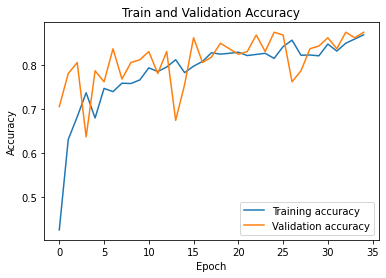

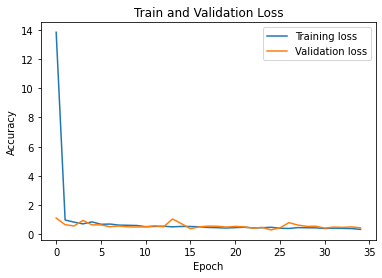

In [16]:
#Accuracy plot
plt.title("Train and Validation Accuracy")
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.legend(["Training accuracy","Validation accuracy"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

#Loss plot
plt.title("Train and Validation Loss")
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(["Training loss","Validation loss"])
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()

Test the model

Saving plast.jpg to plast.jpg


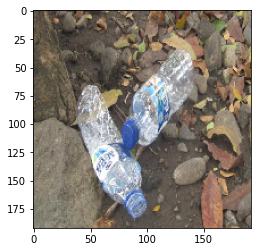

Cardboard: 10.76%
Glass: 0.00%
Metal: 78.89%
Paper: 8.57%
Plastic: 0.02%
Trash: 1.77%


In [25]:
from keras_preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input

uploaded = files.upload()
labels = train_generator.class_indices.keys()

for name in uploaded.keys():
    path = name
    img = image.load_img(path, target_size=(192, 192))
    plt.imshow(img)
    plt.show()
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    images = np.vstack([x])
    probability = model.predict(images)[0]
    for (label, p) in zip(labels, probability):
        print("{}: {:.2f}%".format(label.capitalize(), p * 100))
